# Mount drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/DeepImputation/cross-modality_prediction/

/content/drive/MyDrive/DeepImputation/cross-modality_prediction


In [4]:
!pip install pynrrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.7 MB 9.4 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6


# Load libraries

In [6]:
import os
import tensorflow as tf
from model.UnetGAN_percetual_loss import UnetGAN
from datetime import datetime
import logging
import load as loader
import random
import numpy as np
import nrrd
import lib.metrics as metrics
import time
from os import listdir

In [7]:
tf.__version__

'2.9.2'

# Setting configurations

In [8]:
tf_summary = tf.compat.v1.summary

####Delete all flags before declare#####

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.compat.v1.flags.FLAGS)


tf.compat.v1.flags.DEFINE_integer('batch_size', 1, 'batch size, default: 1')

tf.compat.v1.flags.DEFINE_integer('image_size_z', 144, 'image size z dimension')
tf.compat.v1.flags.DEFINE_integer('image_size_y', 192, 'image size y dimension')
tf.compat.v1.flags.DEFINE_integer('image_size_x', 160, 'image size x dimension')

tf.compat.v1.flags.DEFINE_bool('test_only', True,
					 'determine whethere test only or train/val/test, default: False')
tf.compat.v1.flags.DEFINE_bool('use_lsgan', True,
					 'use lsgan (mean squared error) or cross entropy loss, default: True')
tf.compat.v1.flags.DEFINE_string('norm', 'instance',
					   '[instance, batch] use instance norm or batch norm, default: instance')
tf.compat.v1.flags.DEFINE_float('learning_rate', 1e-4,
					  'initial learning rate for Adam, default: 0.0002')
tf.compat.v1.flags.DEFINE_float('beta1', 0.5,
					  'momentum term of Adam, default: 0.5')
tf.compat.v1.flags.DEFINE_integer('ngf', 64,
						'number of gen filters in first conv layer, default: 64')
tf.compat.v1.flags.DEFINE_integer('early_stop', 20, 'early stop for the number of epochs which does not increase ssim, default: 64')
tf.compat.v1.flags.DEFINE_float('lamda_l1', 25.0,
					  'coefficient of l1 norm, default: 100')
tf.compat.v1.flags.DEFINE_float('beta_cor', 0.0,
					  'coefficient of l1 norm, default: 0.0')
tf.compat.v1.flags.DEFINE_float('lamda_p', 25.0,
					  'coefficient of l1 norm, default: 0.0')
tf.compat.v1.flags.DEFINE_string("GPU", "0", "GPU to use")

tf.compat.v1.flags.DEFINE_string('load_model', '20220217-1531',
					   'folder of saved model that you wish to continue training (e.g. 20170602-1936), default: None')
tf.compat.v1.flags.DEFINE_integer('start_step', 0,
						'number of gen filters in first conv layer, default: 0')
tf.compat.v1.flags.DEFINE_string('weight_dir', 'model_weights/unet_3d.pkl',
					   'the dir of weight file for fine tune')
tf.compat.v1.flags.DEFINE_string('checkpoints_dir', 'checkpoints/PGAN_T1toT2_EBDS_IBIS_resampled_1year/',
					   'the dir for checkpoints')

FLAGS = tf.compat.v1.flags.FLAGS


run_config = tf.compat.v1.ConfigProto()	
run_config.gpu_options.allow_growth=True

tf.compat.v1.flags.DEFINE_string('f', '', 'kernel')


In [9]:
object_shape = (160,192,144)
def get_checkpoint_dir():
	current_time = datetime.now().strftime("%Y%m%d-%H%M")
	checkpoints_dir = os.path.join(FLAGS.checkpoints_dir, current_time)

	try:
		os.makedirs(checkpoints_dir)
	except os.error:
		pass

	return checkpoints_dir



In [10]:
def crop(img, object_shape, crop_indices=None):
    img = img.transpose((2, 1, 0))    
    img_tmp = img
    if img[0,0,0] != 0:
        img_tmp[img==img[0,0,0]] = 0
    if crop_indices is None:
        crop_indices = np.zeros(6,dtype=np.int32)
        # step 1: crop the brain from the original image
        index_nonzero = np.argwhere(img_tmp > 0)

        index_z_begin = np.min(index_nonzero[:, 0])
        index_z_end = np.max(index_nonzero[:, 0])

        index_y_begin = np.min(index_nonzero[:, 1])
        index_y_end = np.max(index_nonzero[:, 1])

        index_x_begin = np.min(index_nonzero[:, 2])
        index_x_end = np.max(index_nonzero[:, 2])
        
        crop_indices[0] = index_z_begin
        crop_indices[1] = index_z_end
        crop_indices[2] = index_y_begin
        crop_indices[3] = index_y_end
        crop_indices[4] = index_x_begin
        crop_indices[5] = index_x_end
    else:
        index_z_begin = crop_indices[0]
        index_z_end = crop_indices[1]
        index_y_begin = crop_indices[2]
        index_y_end = crop_indices[3]
        index_x_begin = crop_indices[4]
        index_x_end = crop_indices[5]

    img_crop = img[index_z_begin:index_z_end, index_y_begin:index_y_end, index_x_begin: index_x_end]

    z_crop, y_crop, x_crop = img_crop.shape

    if z_crop > object_shape[0] or y_crop > object_shape[1] or x_crop > object_shape[2]:
        print ("images are bigger than the cropping sizes")
        print (index_z_begin, index_z_end, index_y_begin, index_y_end, index_x_begin, index_x_end)
        return

    # step 2: padding
    img_padding = np.zeros(object_shape, dtype=np.float32)

    original_shape = img_crop.shape
    index_z_begin_new = int((object_shape[0] - original_shape[0]) / 2)
    index_z_end_new = index_z_begin_new + original_shape[0]

    index_y_begin_new = int((object_shape[1] - original_shape[1]) / 2)
    index_y_end_new = index_y_begin_new + original_shape[1]

    index_x_begin_new = int((object_shape[2] - original_shape[2]) / 2)
    index_x_end_new = index_x_begin_new + original_shape[2]

    img_padding[index_z_begin_new: index_z_end_new, index_y_begin_new: index_y_end_new,
    index_x_begin_new: index_x_end_new] = img_crop

    img_padding = img_padding.transpose((2, 1, 0))

    return img_padding, crop_indices

# Test function

In [11]:

# model setting
concrete_model_name = FLAGS.load_model
# mode = 't1_to_t2'  # t1_to_t2 or t2_to_t1
method = 'PGAN_T1toT2_EBDS_resampled_1year'
checkpoints_dir = os.path.join(FLAGS.checkpoints_dir, concrete_model_name)


graph = tf.Graph()
with graph.as_default():
	input_src = tf.compat.v1.placeholder(tf.float32, shape=[FLAGS.batch_size, FLAGS.image_size_z, FLAGS.image_size_y,
															FLAGS.image_size_x, 1])
	input_tar = tf.compat.v1.placeholder(tf.float32, shape=[FLAGS.batch_size, FLAGS.image_size_z, FLAGS.image_size_y,
															FLAGS.image_size_x, 1])
	ph_ssim = tf.compat.v1.placeholder(tf.float32, name='ssim')
	tf_summary.scalar(name='ssim', tensor=ph_ssim)

	unet_gan = UnetGAN(
		input_src,
		input_tar,
		condition=None,
		weight_dir=FLAGS.weight_dir,
		batch_size=FLAGS.batch_size,
		image_size_z=FLAGS.image_size_z,
		image_size_y=FLAGS.image_size_y,
		image_size_x=FLAGS.image_size_x,
		use_lsgan=FLAGS.use_lsgan,
		norm=FLAGS.norm,
		lamda_l1=FLAGS.lamda_l1,
		beta_cor=FLAGS.beta_cor,
		lamda_p=FLAGS.lamda_p,
		learning_rate=FLAGS.learning_rate,
		beta1=FLAGS.beta1,
		ngf=FLAGS.ngf
	)

	G_loss, D_Y_loss, fake_y = unet_gan.model()
	#optimizers = unet_gan.optimize(G_loss, D_Y_loss)

	optimizer_G = unet_gan.optimize_G(G_loss)
	optimizer_D = unet_gan.optimize_D(D_Y_loss)

	summary_op = tf.compat.v1.summary.merge_all()
	saver = tf.compat.v1.train.Saver()

with tf.compat.v1.Session(graph=graph) as sess:

	model_names = os.listdir(checkpoints_dir)
	model_names.sort(reverse=True)
	model_names = list(filter(lambda x: '.meta' in x, model_names))

	print('start loading model ...')

	meta_graph_path = os.path.join(checkpoints_dir, model_names[0])
	restore = tf.compat.v1.train.import_meta_graph(meta_graph_path)
	restore.restore(sess, os.path.join(checkpoints_dir, os.path.splitext(model_names[0])[0]))

	# test
	template = 'image_sample.nrrd'
	_, header = nrrd.read(template)
	original_shape = (195, 233, 159)
	crop_indices = [int((original_shape[0] - FLAGS.image_size_x)/2),int((original_shape[0] - FLAGS.image_size_x)/2)+FLAGS.image_size_x,
			int((original_shape[1] - FLAGS.image_size_y)/2),int((original_shape[1] - FLAGS.image_size_y)/2)+FLAGS.image_size_y,
			int((original_shape[2] - FLAGS.image_size_z)/2),int((original_shape[2] - FLAGS.image_size_z)/2)+FLAGS.image_size_z]
	index_z_begin = crop_indices[0]
	index_z_end = crop_indices[1]
	index_y_begin = crop_indices[2]
	index_y_end = crop_indices[3]
	index_x_begin = crop_indices[4]
	index_x_end = crop_indices[5]
	# initialize measurements
	test_feed_dict = {}

	subj_id = 'image_sample'
	img_T1, header = nrrd.read('image_sample.nrrd')
	img_T1 = img_T1.transpose((2, 1, 0))
	img_T1[img_T1<0.0] = 0.0
	crop_indices = [int((original_shape[0] - object_shape[0])/2),int((original_shape[0] - object_shape[0])/2)+object_shape[0],
			int((original_shape[1] - object_shape[1])/2),int((original_shape[1] - object_shape[1])/2)+object_shape[1],
			int((original_shape[2] - object_shape[2])/2),int((original_shape[2] - object_shape[2])/2)+object_shape[2]
	]
	img_T1, _ = crop(img_T1, object_shape, crop_indices)


	min_val_T1 = np.percentile(img_T1, 1) 
	min_val_T1 = np.maximum(min_val_T1,img_T1[0,0,0])
	max_val_T1 = np.percentile(img_T1, 99)
	img_T1 = (img_T1 - min_val_T1) / (max_val_T1 - min_val_T1)
	img_T1[img_T1 < 0] = 0
	img_T1[img_T1 > 1] = 1
	print ("Minval: ", min_val_T1, ",Maxval: ", max_val_T1)
	img_T1 = np.expand_dims(img_T1, axis=-1)
	img_T1 = np.expand_dims(img_T1, axis=0)

	print("test subj id: ", subj_id)
	x_test = img_T1
	# normalize to [-1,1] 
	x_test = x_test * 2 - 1

	test_feed_dict = {input_src: x_test, unet_gan.is_training: False}
	fake_y_test = (sess.run(fake_y, feed_dict=test_feed_dict))


	outbase = subj_id

	generated_t2 = fake_y_test[0, :, :, :, 0].transpose([2, 1, 0])
	# normalize from [-1,1] to [0,1]

	generated_t2 = 0.5*(generated_t2 + 1.0)

	generated_t2_pad = np.zeros(original_shape, dtype=np.float32)

	generated_t2_pad[index_z_begin:index_z_end, index_y_begin:index_y_end, index_x_begin:index_x_end] = generated_t2
	print ("Saving images...")
	nrrd.write(os.path.join('%s-T2_Imputed.nrrd' % outbase), generated_t2_pad, header=header)

				


model_weights/unet_3d.pkl



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Tensor("max_pooling3d_3/MaxPool3D:0", shape=(None, 72, 96, 80, 64), dtype=float32)
Tensor("max_pooling3d_4/MaxPool3D:0", shape=(None, 36, 48, 40, 128), dtype=float32)
Tensor("max_pooling3d_5/MaxPool3D:0", shape=(None, 18, 24, 20, 256), dtype=float32)
Tensor("depth_7_relu_1/Relu:0", shape=(None, 18, 24, 20, 512), dtype=float32)
start loading model ...
Minval:  0.0 ,Maxval:  2538.0
test subj id:  image_sample
Saving images...


# Visualize results

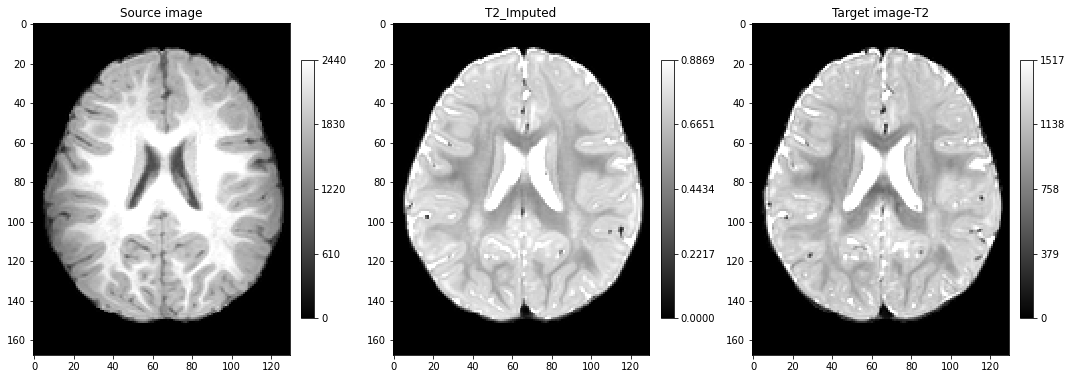

In [14]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
fig.subplots_adjust(hspace=1)

z = 90
sidx = 30
eidx = -35


imgfile = 'image_sample.nrrd'
img, _ = nrrd.read(imgfile)
img = img.transpose((1,0,2))
img = np.flipud(img)

# img = img.transpose((2, 1, 0))
vmax = np.percentile(img,99)
img = img[sidx:eidx,sidx:eidx,z]
im0 = axes[0].imshow(img, interpolation='nearest',cmap='gray',clim=(0.0, vmax))
v = np.linspace(0, vmax, 5, endpoint=True)
fig.colorbar(im0, ax=axes[0],fraction=0.046, pad=0.04, ticks=v)
axes[0].set_title('Source image')

imgfile = 'image_sample-T2_Imputed.nrrd'
img, _ = nrrd.read(imgfile)
img = img.transpose((1,0,2))
img = np.flipud(img)
# img = img.transpose((2, 1, 0))
vmax = np.percentile(img,99)
img = img[sidx:eidx,sidx:eidx,z]
im0 = axes[1].imshow(img, interpolation='nearest',cmap='gray',clim=(0.0, vmax))
v = np.linspace(0, vmax, 5, endpoint=True)
fig.colorbar(im0, ax=axes[1],fraction=0.046, pad=0.04, ticks=v)
axes[1].set_title('T2_Imputed')

imgfile = 'image_sample-T2.nrrd'
img, _ = nrrd.read(imgfile)
img = img.transpose((1,0,2))
img = np.flipud(img)
# img = img.transpose((2, 1, 0))
vmax = np.percentile(img,99)
img = img[sidx:eidx,sidx:eidx,z]
im0 = axes[2].imshow(img, interpolation='nearest',cmap='gray',clim=(0.0, vmax))
v = np.linspace(0, vmax, 5, endpoint=True)
fig.colorbar(im0, ax=axes[2],fraction=0.046, pad=0.04, ticks=v)
axes[2].set_title('Target image-T2')


fig.tight_layout()

plt.show()